In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import os
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dropout

In [161]:
import datatable as dt 
dir_data= "bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv"
dt_df = dt.fread(dir_data)
pd_df = dt_df.to_pandas()
pd_df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
pd_df.shape

(4857377, 8)

In [163]:
# nRowsRead = 1000
# df1 = pd.read_csv(dir_data, delimiter=',', nrows = nRowsRead)
# df1.head()

In [164]:
prediction_days = 50
nof_units =4

Data preprocessing, converting timestamp to day average.

In [165]:
pd_df['date'] = pd.to_datetime(pd_df['Timestamp'],unit='s').dt.date
group = pd_df.groupby('date')
Real_Price = group['Weighted_Price'].mean()

In [166]:
Real_Price.head()

date
2011-12-31    4.471603
2012-01-01    4.806667
2012-01-02    5.000000
2012-01-03    5.252500
2012-01-04    5.208159
Name: Weighted_Price, dtype: float64

In [234]:
df_train= Real_Price[:len(Real_Price)-prediction_days]
df_test= Real_Price[len(Real_Price)-prediction_days:]

(array([18628., 18642., 18659., 18673., 18687., 18701., 18718.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

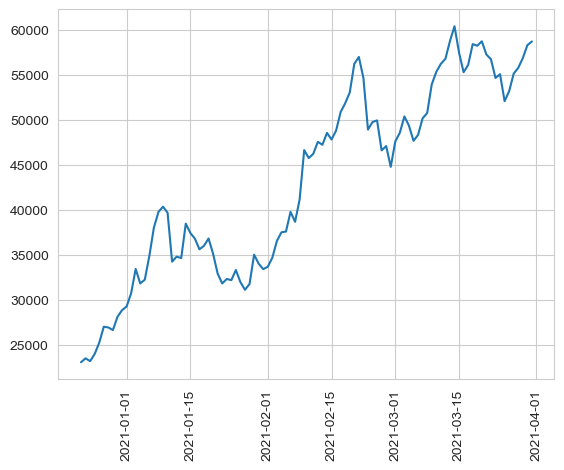

In [168]:
plt.plot(Real_Price[len(Real_Price)-100:], label = 'Real BTC Price')
plt.xticks(rotation = 'vertical')

In [211]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [170]:
def create_model(nunits):
    regressor = Sequential()
    regressor.add(LSTM(units = nunits, activation = 'sigmoid', input_shape=(None,1)))
    regressor.add(Dense(units=1))
    regressor.compile(optimizer='adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return regressor

In [171]:
regressor = create_model(nunits = nof_units)
history = regressor.fit(X_train, y_train, batch_size = 5, epochs = 30)

Epoch 1/30
665/665 [==============================] - 1s 969us/step - loss: 0.0148 - accuracy: 3.0075e-04
Epoch 2/30
665/665 [==============================] - 1s 1ms/step - loss: 0.0123 - accuracy: 3.0075e-04
Epoch 3/30
665/665 [==============================] - 1s 1ms/step - loss: 0.0096 - accuracy: 3.0075e-04
Epoch 4/30
665/665 [==============================] - 1s 1ms/step - loss: 0.0064 - accuracy: 3.0075e-04
Epoch 5/30
665/665 [==============================] - 1s 995us/step - loss: 0.0032 - accuracy: 3.0075e-04
Epoch 6/30
665/665 [==============================] - 1s 1ms/step - loss: 0.0011 - accuracy: 6.0150e-04
Epoch 7/30
665/665 [==============================] - 1s 1ms/step - loss: 2.8399e-04 - accuracy: 6.0150e-04
Epoch 8/30
665/665 [==============================] - 1s 948us/step - loss: 1.3375e-04 - accuracy: 6.0150e-04
Epoch 9/30
665/665 [==============================] - 1s 987us/step - loss: 1.1717e-04 - accuracy: 6.0150e-04
Epoch 10/30
665/665 [=======================

In [215]:
test_set = df_test.values
inputs_1 = np.reshape(test_set, (len(test_set), 1))
inputs_2 = sc.transform(inputs_1)
inputs = np.reshape(inputs_2, (len(inputs_2), 1, 1))
predicted_BTC_price_1 = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price_1)

2/2 [==============================] - 0s 1ms/step


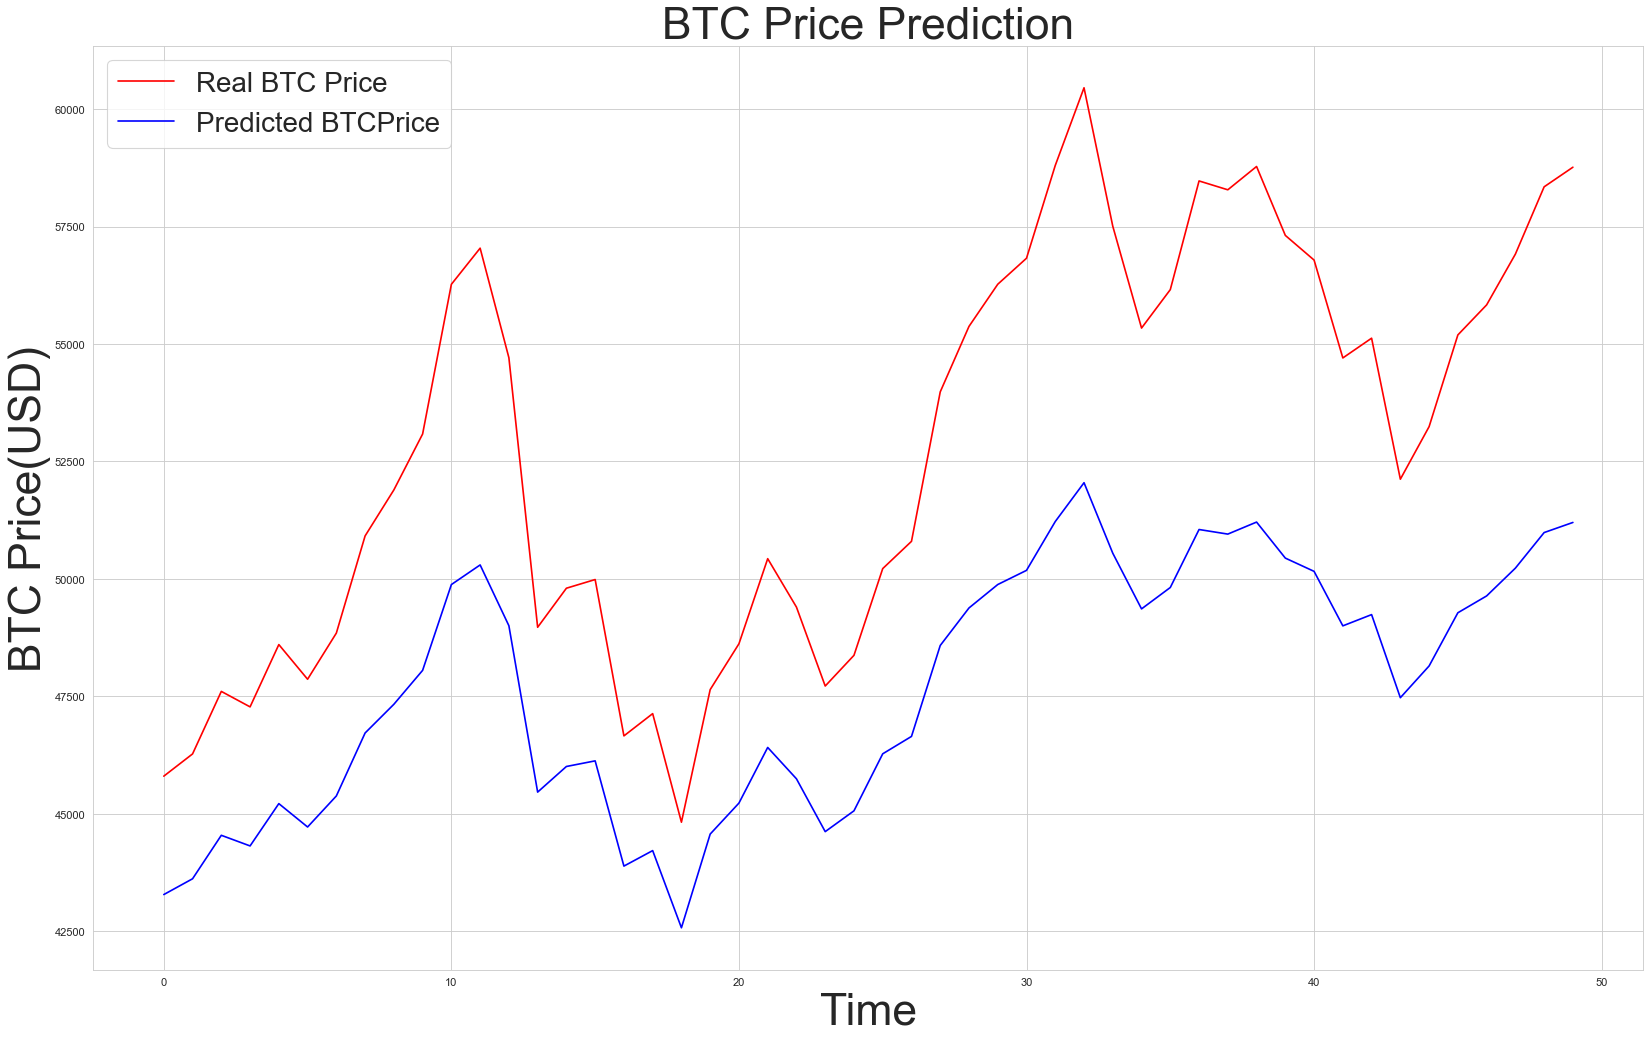

In [216]:
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTCPrice')
plt.title('BTC Price Prediction', fontsize=40)
df_test_1 = df_test.reset_index()
x=df_test_1.index
# labels = df_test_1['date']
# plt.xticks(x, labels, rotation = 'vertical')
# for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(3)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [217]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


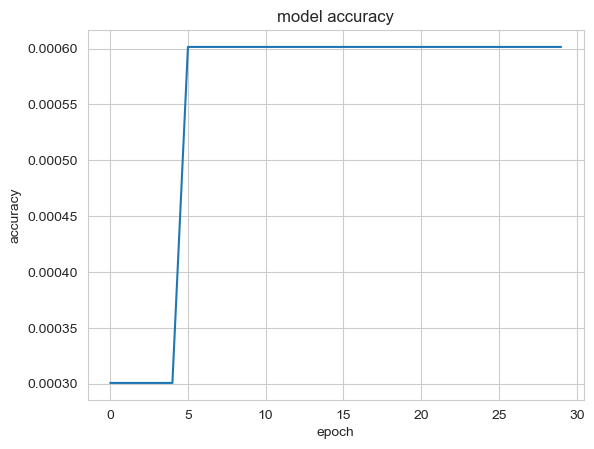

In [218]:
plt.subplots() # open a new plot
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

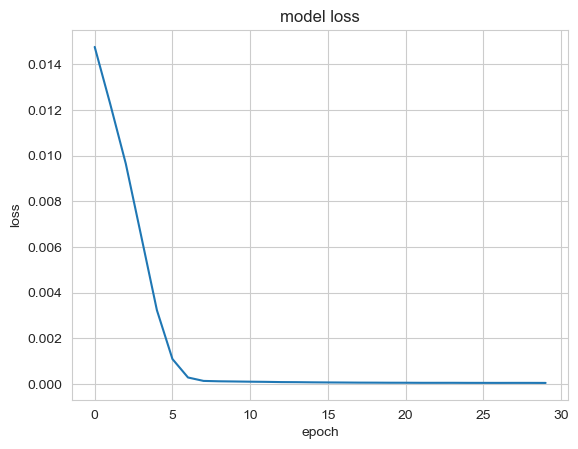

In [219]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [177]:
df_test_1

,date,Weighted_Price
0,2021-02-10,45798.733715
1,2021-02-11,46272.215669
2,2021-02-12,47603.415420
3,2021-02-13,47273.849919
4,2021-02-14,48600.491518
5,2021-02-15,47862.397946
6,2021-02-16,48845.166003
7,2021-02-17,50913.924139
8,2021-02-18,51893.311181
9,2021-02-19,53083.879109


In [178]:
from keras.layers import Dense, SimpleRNN, Dropout,Flatten

In [179]:
X_train.shape

(3325, 1, 1)

In [180]:
def create_model2(nunits):
    regressor = Sequential()
    regressor.add(SimpleRNN(128,activation="relu",return_sequences=True,input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.25))

    regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
    regressor.add(Dropout(0.25))

    regressor.add(SimpleRNN(512,activation="relu",return_sequences=True))
    regressor.add(Dropout(0.35))

    regressor.add(SimpleRNN(256,activation="relu",return_sequences=True))
    regressor.add(Dropout(0.25))

    regressor.add(SimpleRNN(128,activation="relu",return_sequences=True))
    regressor.add(Dropout(0.25))

    regressor.add(Flatten())

    regressor.add(Dense(1))


    regressor.compile(optimizer='adam', loss = 'mean_squared_error',metrics = ['accuracy'])
    return regressor

In [243]:
regressor2 = create_model2(nunits = nof_units)
regressor2.fit(X_train, y_train, batch_size = 5, epochs = 30)

Epoch 1/30
665/665 [==============================] - 6s 4ms/step - loss: 0.0022 - accuracy: 6.0150e-04
Epoch 2/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0026 - accuracy: 6.0150e-04
Epoch 3/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 6.0150e-04
Epoch 4/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0015 - accuracy: 3.0075e-04
Epoch 5/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0017 - accuracy: 6.0150e-04
Epoch 6/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0013 - accuracy: 6.0150e-04
Epoch 7/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0012 - accuracy: 6.0150e-04
Epoch 8/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0014 - accuracy: 6.0150e-04
Epoch 9/30
665/665 [==============================] - 3s 4ms/step - loss: 0.0013 - accuracy: 6.0150e-04
Epoch 10/30
665/665 [==============================] - 3s 4ms/st

In [244]:
predicted_BTC_price_RNN = regressor2.predict(inputs)
predicted_BTC_price_RNN = sc.inverse_transform(predicted_BTC_price_RNN)

2/2 [==============================] - 1s 3ms/step


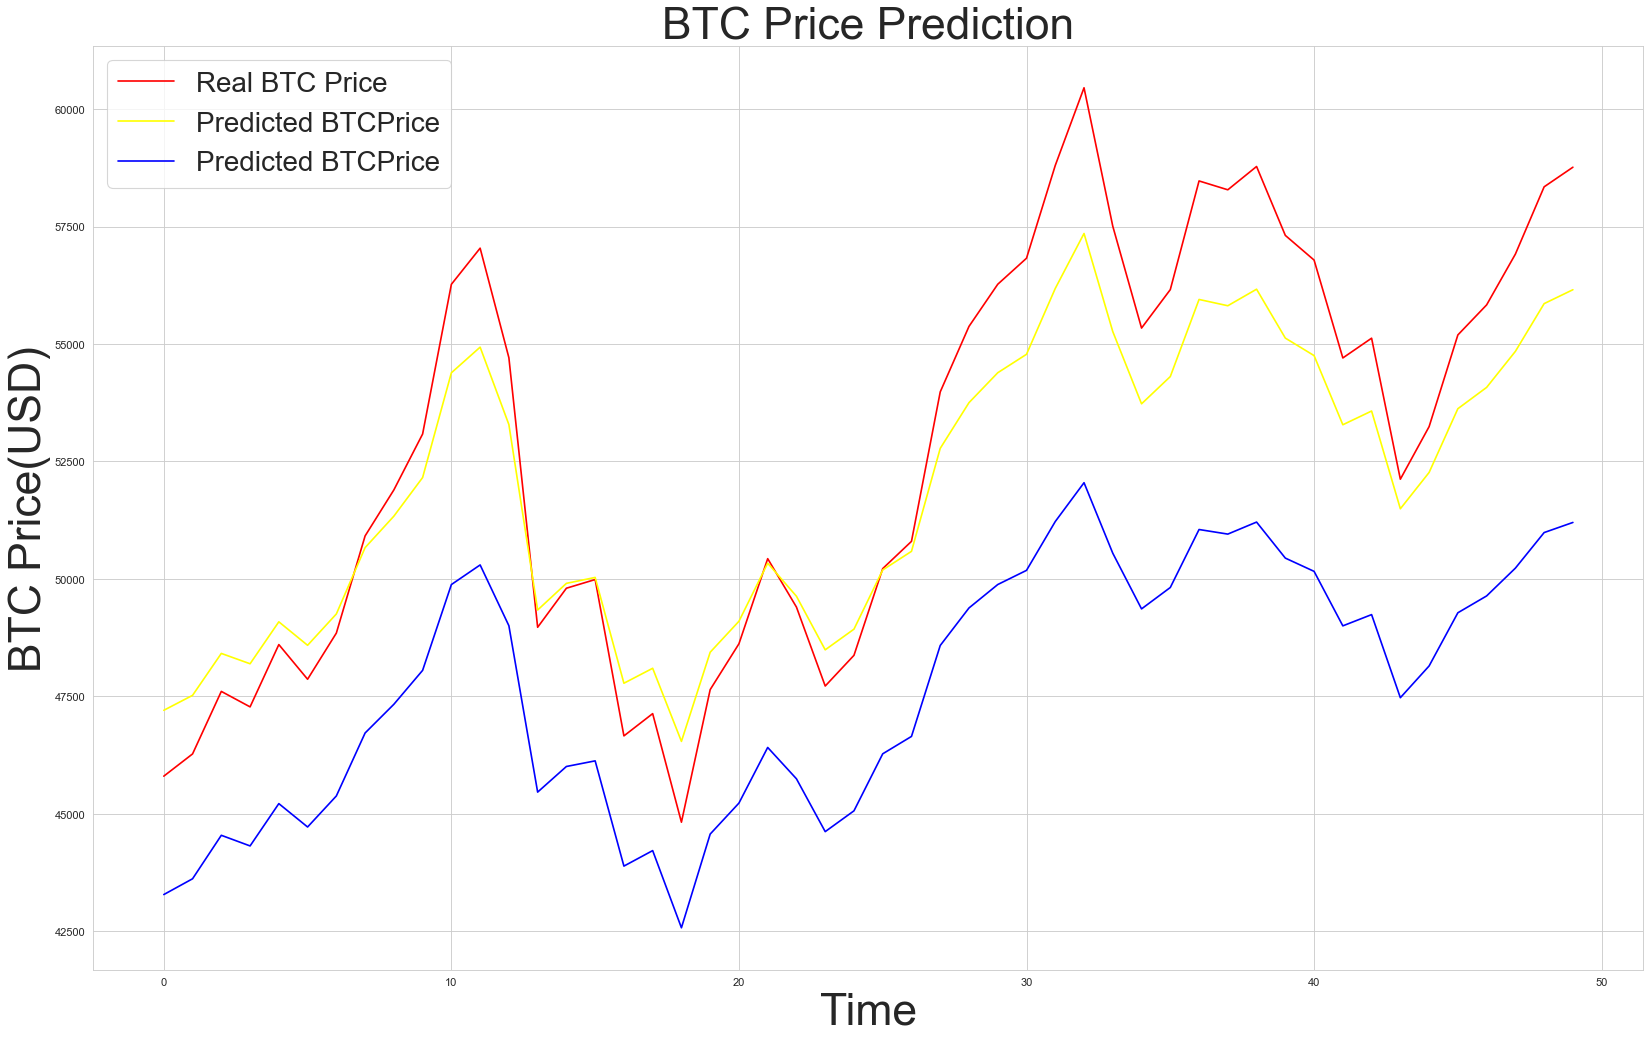

In [247]:

plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()
plt.plot(test_set, color = 'red', label = 'Real BTC Price')
plt.plot(predicted_BTC_price_RNN, color = 'yellow', label = 'Predicted BTCPrice')
plt.plot(predicted_BTC_price, color = 'blue', label = 'Predicted BTCPrice')
plt.title('BTC Price Prediction', fontsize=40)
# df_test_1 = df_test.reset_index()
# x=df_test_1.index
# labels = df_test['date']
# plt.xticks(x, labels, rotation = 'vertical')
# for tick in ax.xaxis.get_major_ticks():
#     tick.label1.set_fontsize(18)
# for tick in ax.yaxis.get_major_ticks():
#     tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD)', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

In [232]:
from sklearn.impute import KNNImputer
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv')
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')
df.set_index('Timestamp', inplace=True)
df = df.resample('D').mean()
Kimp = KNNImputer(n_neighbors=10)
df = pd.DataFrame(Kimp.fit_transform(df), index=df.index, columns=df.columns)

In [186]:
def normalize(data):
    mean = data.mean()
    std = data.std()
    return (data-mean)/std


df_norm = normalize(df)

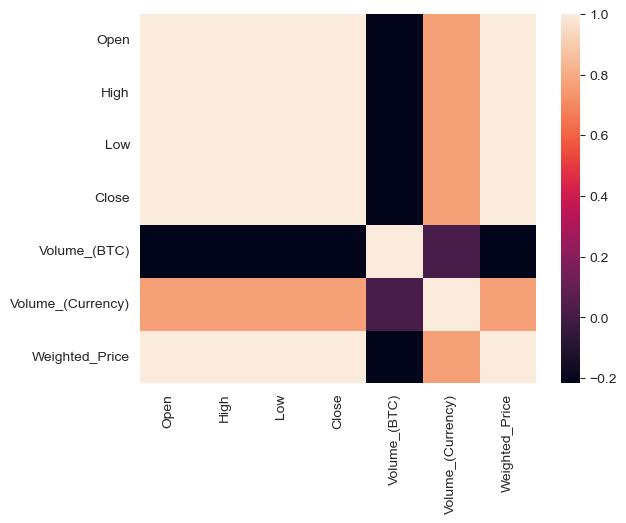

In [187]:
sns.heatmap(df_norm.corr())
# create vif dataframe
vif = pd.DataFrame()
vif['vif_factor'] = [variance_inflation_factor(df_norm.values, i) for i in range(df_norm.shape[1])]
vif['feature'] = df.columns

# get rid of 'Volume_(Currency)' which has the highest multiCollinearity
df_norm.drop('Volume_(Currency)', axis=1, inplace=True)

In [188]:
cols = df_norm.columns
for col in cols:
    print("Augmented Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_norm[col])[1])

Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=1.000000
Augmented Dickey–Fuller test: p=0.000394
Augmented Dickey–Fuller test: p=1.000000


In [189]:
def data_for_rnn(input, seq_len):
    x_li = []
    x_idx = input.index[seq_len-1:-1]
    for i in range(len(input)-seq_len):
        x_li.append(input.iloc[i:i+seq_len].values)
    return x_li, x_idx

def RNNmodel(out_shape, seq_len, n_feature):
    out_shape = out_shape

    model = models.Sequential()
    model.add(layers.Input(shape=(seq_len, n_feature), name='input'))
    model.add(layers.LSTM(128, activation='relu', return_sequences=True, name='first'))
    model.add(layers.LSTM(64, activation='relu', name='second'))
    model.add(layers.Dense(out_shape))
    model.summary()
    model.compile(optimizer='adam',
                  loss = 'mse',
                  metrics=['accuracy'])
    return model

In [190]:
seq_len = 20

x_rnn, x_idx = data_for_rnn(df_norm['Weighted_Price'], seq_len)
x_rnn = tf.convert_to_tensor(np.expand_dims(x_rnn, axis=2))

y = df['Weighted_Price'].iloc[20:]
y = normalize(y)
y_rnn = tf.convert_to_tensor(np.expand_dims(y, axis=1))

trn_size = int(len(x_rnn)*0.7)
val_size = int(len(x_rnn)*0.1)

x_trn = x_rnn[:trn_size]
x_val = x_rnn[trn_size:trn_size+val_size]
x_tst = x_rnn[trn_size+val_size:]


y_trn = y_rnn[:trn_size]
y_val = y_rnn[trn_size:trn_size+val_size]
y_tst = y_rnn[trn_size+val_size:]

In [191]:
model = RNNmodel(out_shape=1, seq_len=seq_len, n_feature=1)
model.summary()
model.fit(x_trn, y_trn, epochs=40, validation_data=(x_val, y_val))

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (LSTM)                (None, 20, 128)           66560     
                                                                 
 second (LSTM)               (None, 64)                49408     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first (LSTM)                (None, 20, 128)           66560     
                                                                 
 second (LSTM)          

22/22 [==============================] - 0s 5ms/step


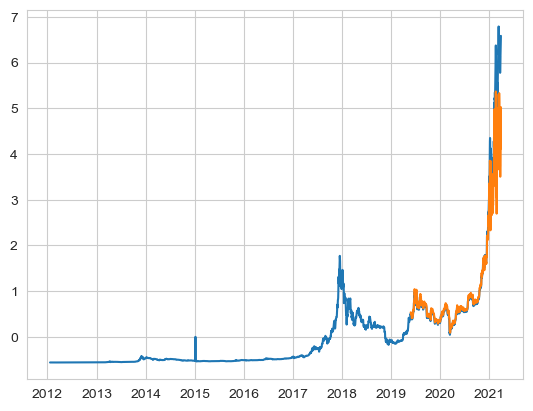

In [192]:
pred = model.predict(x_tst)
pred_df = pd.DataFrame(pred, index=y.index[+trn_size+val_size:])
plt.plot(y)
plt.plot(pred_df)
plt.show()